In [1]:
import numpy as np
import pandas as pd
import os
import re
import csv
import matplotlib.pyplot as plt

In [ ]:
base_path = "raw data from openfoam"

all_folders = os.listdir(base_path)

numeric_folders = sorted(
    [folder for folder in all_folders if folder.replace('.', '').isdigit()],
    key=lambda x: float(x)
)

output_dir = "processed_data"
os.makedirs(output_dir, exist_ok=True)

for folder in numeric_folders:
    folder_path = os.path.join(base_path, folder)
    if os.path.isdir(folder_path):
        u_file_path = os.path.join(folder_path, "U")
        if os.path.isfile(u_file_path):
            with open(u_file_path, 'r') as file:
                lines = file.readlines()
                ux_data = []
                in_data_section = False
                
                for line in lines:
                    line = line.strip()
                    if line.startswith("internalField"):
                        in_data_section = True
                        continue
                    if in_data_section:
                        if line.startswith(")"):
                            break
                        match = re.match(r"\(([\d\-eE.+]+) [\d\-eE.+]+ [\d\-eE.+]+\)", line)
                        if match:
                            ux = float(match.group(1)) 
                            ux_data.append(ux)

                csv_file = os.path.join(output_dir, f"{folder}_ux_data.csv")
                with open(csv_file, "w", newline="") as csvfile:
                    writer = csv.writer(csvfile)
                    writer.writerow(["ux"])
                    writer.writerows([[value] for value in ux_data])
                print(f"Saved {len(ux_data)} entries for folder {folder} to {csv_file}")

def load_csv_data(folder_name):
    csv_file = os.path.join(output_dir, f"{folder_name}_ux_data.csv")
    if os.path.isfile(csv_file):
        data = np.loadtxt(csv_file, delimiter=",", skiprows=1)
        return data
    else:
        print(f"No data file found for folder: {folder_name}")
        return None

folder_to_process = "0.2"
ux_data = load_csv_data(folder_to_process)
if ux_data is not None:
    print(f"Loaded {len(ux_data)} entries from folder {folder_to_process}")
    print(f"Average ux: {np.mean(ux_data):.6f}")


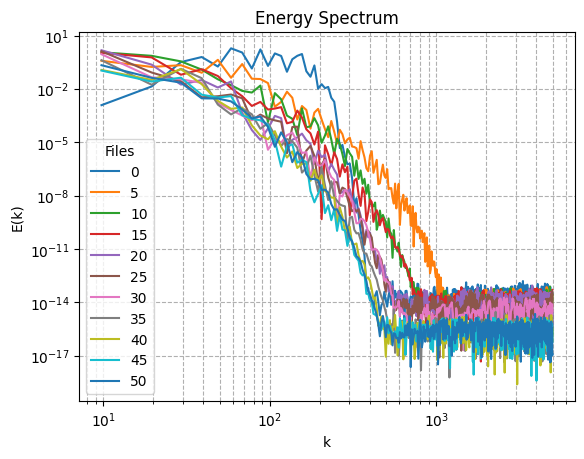

In [51]:
# Energy spectrum of boundary

def compute_energy_spectrum(data, dx=0.0001):
    N = len(data)
    fft_data = np.fft.fft(data)  # Fourier Transform
    fft_data = np.abs(fft_data[:N//2])
    E_k = (1/2) * (fft_data ** 2) / N  # Energy spectrum normalization
    k = np.fft.fftfreq(N, d=dx)[:N//2]
    return k, E_k
    
files =[
    '../proceed_data/proceed_data_v_10/processed_data/0_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/5_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/10_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/15_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/20_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/25_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/30_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/35_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/40_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/45_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/50_ux_data.csv'
]

for file in files:
    data = pd.read_csv(file, header=None, dtype=str).squeeze()
    data = pd.to_numeric(data, errors='coerce')
    data = data.dropna().values
    data = data[0:1024]
    
    # Compute
    k, E_k = compute_energy_spectrum(data)
    label = file.split('/')[-1].split('_')[0]
    plt.loglog(k[1:], E_k[1:], label=label)

plt.title("Energy Spectrum")
plt.xlabel("k")
plt.ylabel("E(k)")
plt.legend(title="Files", loc="best")
plt.grid(True, which="both", linestyle="--")
plt.show()

In [35]:
kinetic_energies = []

for filepath in files:
    # Load and preprocess data
    data = pd.read_csv(filepath, header=None, dtype=str).squeeze()
    data = pd.to_numeric(data, errors='coerce')
    data = data.dropna().values
    data = data[0:1024]
    
    k, E_k = compute_energy_spectrum(data)
    
    kinetic_energy = np.trapz(E_k[1:], k[1:])
    kinetic_energies.append((filepath.split('/')[-1], kinetic_energy))

for filename, energy in kinetic_energies:
    print(f"t={filename}, Total Kinetic Energy={energy:.4f}")


t=0_ux_data.csv, Total Kinetic Energy=10.1821
t=5_ux_data.csv, Total Kinetic Energy=1.4533
t=10_ux_data.csv, Total Kinetic Energy=1.8145
t=15_ux_data.csv, Total Kinetic Energy=1.3528
t=20_ux_data.csv, Total Kinetic Energy=1.0349
t=25_ux_data.csv, Total Kinetic Energy=0.7635
t=30_ux_data.csv, Total Kinetic Energy=0.5355
t=35_ux_data.csv, Total Kinetic Energy=0.3895
t=40_ux_data.csv, Total Kinetic Energy=0.2347
t=45_ux_data.csv, Total Kinetic Energy=0.1314
t=50_ux_data.csv, Total Kinetic Energy=0.1762


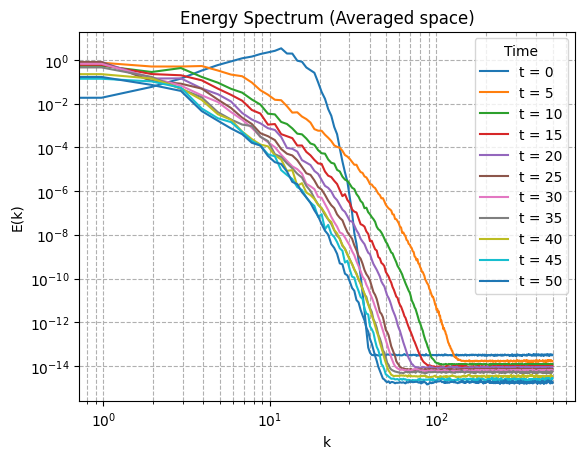

In [36]:
# Energy Spectrum (Averaged across space)
def Energy_sepctrum_Averaged(files):
    for file in files:
        data = pd.read_csv(file, header=None, dtype=str).apply(pd.to_numeric, errors='coerce').dropna().values
        data = data.reshape(1024, 1024)
        
        all_spectra = []
        for row in data:
            k, E_k = compute_energy_spectrum(row)
            all_spectra.append(E_k)
        
        mean_E_k = np.mean(all_spectra, axis=0)
        
        label = file.split('/')[-1].split('_')[0]
        plt.loglog(k[:], mean_E_k[:], label=f"t = {label}")
        
Energy_sepctrum_Averaged(files)

plt.title("Energy Spectrum (Averaged space)")
plt.xlabel("k")
plt.ylabel("E(k)")
plt.legend(title="Time", loc="best")
plt.grid(True, which="both", linestyle="--")
plt.show()

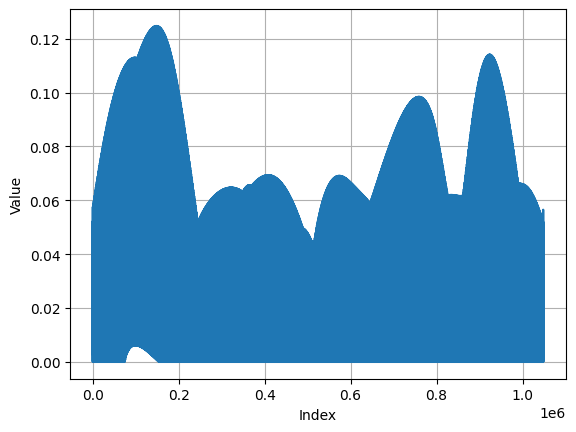

In [37]:
#distritution of u
DataLen = 1024 * 1024
x = np.linspace(0, DataLen, DataLen)
file = '../proceed_data/proceed_data_v_10/processed_data/50_ux_data.csv'

data = pd.read_csv(file, header=None, dtype=str).apply(pd.to_numeric, errors='coerce').dropna().values
allU = []

for row in data:
    allU.extend(row)
allu = [abs(x) for x in allU]

plt.plot(x[:len(allU)], allu)
plt.xlabel("Index")
plt.ylabel("Value")
plt.grid(True)


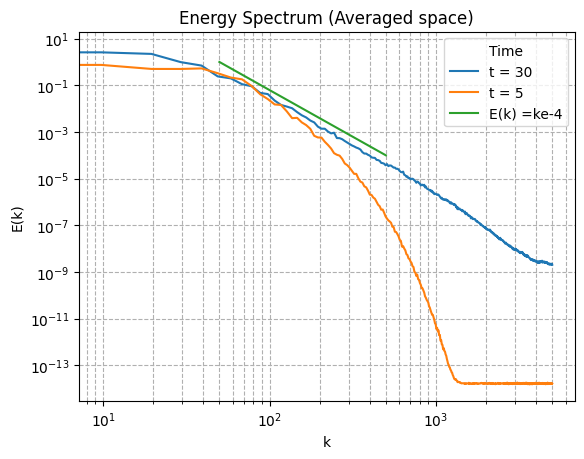

In [55]:
files = [
    '../proceed_data/proceed_data_v_em1/processed_data/30_ux_data.csv',
    '../proceed_data/proceed_data_v_10/processed_data/5_ux_data.csv',
]

Energy_sepctrum_Averaged(files)

k_a = np.logspace(0, 1, 500)  # From 10^-1 to 10^3 (logarithmic scale)
E_k_a = (k_a)**-4
k_a_sh = k_a * 50

plt.loglog(k_a_sh, E_k_a, label="E(k) =ke-4")
plt.title("Energy Spectrum (Averaged space)")
plt.xlabel("k")
plt.ylabel("E(k)")
plt.legend(title="Time", loc="best")
plt.grid(True, which="both", linestyle="--")
plt.show()
